In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from string import punctuation
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-02 15:34:53.043697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 15:34:53.043861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 15:34:53.220498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


In [3]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)
df_full = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')
# Add 'words count' column
df_full['words count'] = df_full['Review Text'].fillna('').apply(lambda x: len(x.split(' ')))

In [4]:
zero_labels_count = df_full['Recommended IND'].value_counts()[0]
one_labels_count = df_full['Recommended IND'].value_counts()[1]
total = zero_labels_count + one_labels_count
print(f"zero: {zero_labels_count/total:.2%}, one: {one_labels_count/total:.2%}")

zero: 17.76%, one: 82.24%


In [5]:
df_full = df_full.query("`Class Name` != 'Casual bottoms' and `Class Name` != 'Chemises'")

In [6]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

nlp = spacy.load("en_core_web_sm")

def extract_adjectives(text):
    # Process the text
    doc = nlp(text)
    # Extract adjectives
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    return ' '.join(adjectives)

In [7]:
# Apply the function to fill in missing titles
df_full['Title'] = df_full.apply(
    lambda row: extract_adjectives(row['Review Text']) if pd.notna(row['Review Text']) and pd.isna(row['Title']) else row['Title'],
    axis=1
)


In [ ]:
df_full

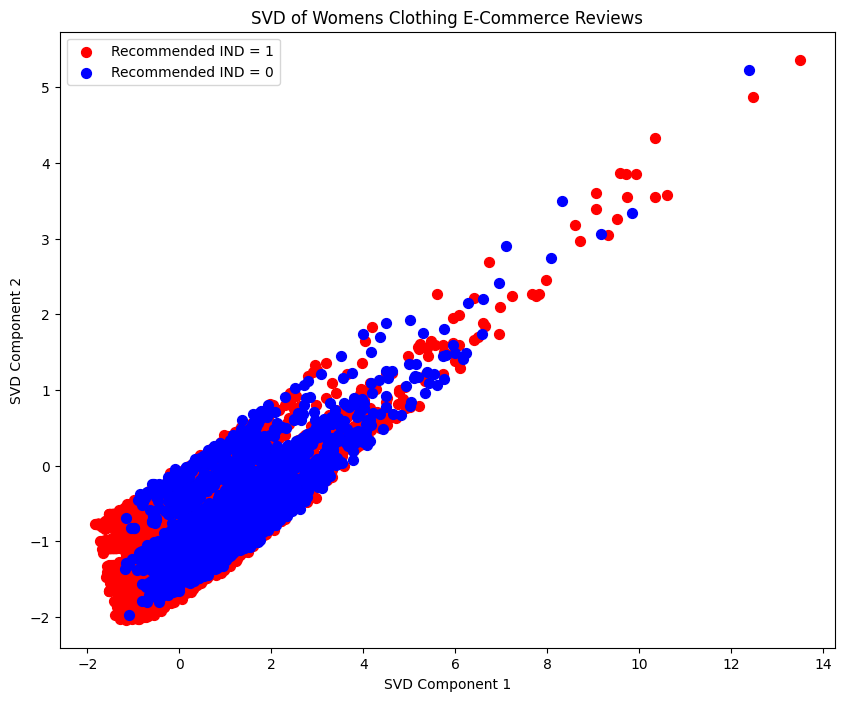

Data after SVD transformation:
   SVD Component 1  SVD Component 2  Recommended IND
0        -1.300117        -0.639015                1
1         0.649141        -1.025006                1
2         1.706357        -0.698952                0
3        -0.966419        -0.991368                1
4         0.222170        -1.397068                1


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# Load your dataset here
# df_full = pd.read_csv('your_dataset.csv')

# Drop unnecessary column if exists
# df_full = df_full.drop(columns=['Unnamed: 0'])

# Fill missing values for 'Title' and 'Review Text' with empty string
df_full['Title'].fillna('', inplace=True)
df_full['Review Text'].fillna('', inplace=True)

# Define the features to be used
features = ['Age', 'Title', 'Review Text', 'Rating', 'Positive Feedback Count', 
            'Division Name', 'Department Name', 'Class Name', 'words count']

# Preprocess and transform the data
numeric_features = ['Age', 'Rating', 'Positive Feedback Count', 'words count']
categorical_features = ['Division Name', 'Department Name', 'Class Name']
text_features = ['Title', 'Review Text']

# Create a column transformer with appropriate transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('text_title', TfidfVectorizer(max_features=100), 'Title'),
        ('text_review', TfidfVectorizer(max_features=500), 'Review Text')
    ])

# Fit and transform the data
X_transformed = preprocessor.fit_transform(df_full[features])

# Reduce dimensions for visualization using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_transformed)

# Extract labels
labels = df_full['Recommended IND']

# Plot the SVD components with labels
plt.figure(figsize=(10, 8))
# Plot Recommended IND = 1 with red color
plt.scatter(X_svd[labels == 1, 0], X_svd[labels == 1, 1], s=50, c='red', label='Recommended IND = 1')
# Plot Recommended IND = 0 with blue color
plt.scatter(X_svd[labels == 0, 0], X_svd[labels == 0, 1], s=50, c='blue', label='Recommended IND = 0')
plt.title('SVD of Womens Clothing E-Commerce Reviews')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.show()

# Print the resulting dataframe with SVD components and labels
df_svd = pd.DataFrame(X_svd, columns=['SVD Component 1', 'SVD Component 2'])
df_svd['Recommended IND'] = labels.values
print("Data after SVD transformation:")
print(df_svd.head())


In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Drop unnecessary column
#df_full = df_full.drop(columns=['Unnamed: 0'])

# Fill missing values for 'Title' and 'Review Text' with empty string
df_full['Title'].fillna('', inplace=True)
df_full['Review Text'].fillna('', inplace=True)

# Define the features to be used
features = ['Age', 'Title', 'Review Text', 'Rating', 'Positive Feedback Count', 
            'Division Name', 'Department Name', 'Class Name', 'words count']

# Preprocess and transform the data
numeric_features = ['Age', 'Rating', 'Positive Feedback Count', 'words count']
categorical_features = ['Division Name', 'Department Name', 'Class Name']
text_features = ['Title', 'Review Text']

# Create a column transformer with appropriate transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('text_title', TfidfVectorizer(max_features=100), 'Title'),
        ('text_review', TfidfVectorizer(max_features=500), 'Review Text')
    ])

# Create a pipeline that first transforms the data and then applies KMeans
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Fit the pipeline to the data and predict the clusters
df_full['Cluster'] = pipeline.fit_predict(df_full[features])

# Check distribution of the clusters
print(df_full['Cluster'].value_counts())

# Separate into two clusters
df_cluster_0 = df_full[df_full['Cluster'] == 0]
df_cluster_1 = df_full[df_full['Cluster'] == 1]

# Resample to balance the clusters
if len(df_cluster_0) > len(df_cluster_1):
    df_cluster_0_downsampled = resample(df_cluster_0, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(df_cluster_1),     # to match minority class
                                        random_state=42)  # reproducible results
    df_balanced = pd.concat([df_cluster_0_downsampled, df_cluster_1])
else:
    df_cluster_1_downsampled = resample(df_cluster_1, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(df_cluster_0),     # to match minority class
                                        random_state=42)  # reproducible results
    df_balanced = pd.concat([df_cluster_0, df_cluster_1_downsampled])

# Map clusters to labels (0 for Non Recommendation, 1 for Recommendation)
df_full['Label'] = df_balanced['Cluster'].map({0: 0, 1: 1}).astype('int64')

# Drop the Cluster column as it's no longer needed
df_full = df_full.drop(columns=['Cluster'])

# Save the new dataframe to a new CSV file
output_file_path = 'Womens Clothing E-Commerce Reviews with Soft Labels.csv'
df_full.to_csv(output_file_path, index=False)

df_full



/tmp/ipykernel_34/2516831244.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full['Title'].fillna('', inplace=True)
/tmp/ipykernel_34/2516831244.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

Cluster
0    12139
1    11344
Name: count, dtype: int64


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,words count,Label
0,0,767,33,wonderful silky sexy comfortable,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,0.0
1,1,1080,34,pretty glad online petite petite little true p...,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,67,1.0
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,1.0
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,0.0
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,28,0.0
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,37,0.0
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,42,0.0
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,86,1.0


/tmp/ipykernel_33/696920438.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full['Title'].fillna('', inplace=True)
/tmp/ipykernel_33/696920438.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

Distribution of clusters:
Cluster
1    11274
0    11274
Name: count, dtype: int64


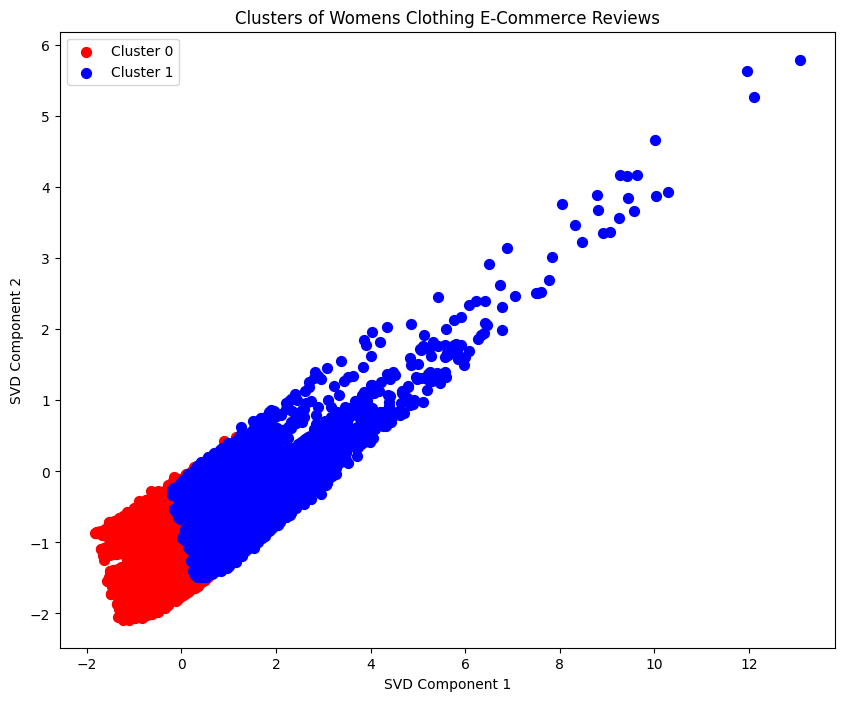

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD

# Load your dataset here
# df_full = pd.read_csv('your_dataset.csv')

# Drop unnecessary column if exists
# df_full = df_full.drop(columns=['Unnamed: 0'])

# Fill missing values for 'Title' and 'Review Text' with empty string
df_full['Title'].fillna('', inplace=True)
df_full['Review Text'].fillna('', inplace=True)

# Define the features to be used
features = ['Age', 'Title', 'Review Text', 'Rating', 'Positive Feedback Count', 
            'Division Name', 'Department Name', 'Class Name', 'words count']

# Preprocess and transform the data
numeric_features = ['Age', 'Rating', 'Positive Feedback Count', 'words count']
categorical_features = ['Division Name', 'Department Name', 'Class Name']
text_features = ['Title', 'Review Text']

# Create a column transformer with appropriate transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('text_title', TfidfVectorizer(max_features=100), 'Title'),
        ('text_review', TfidfVectorizer(max_features=500), 'Review Text')
    ])

# Create a pipeline that first transforms the data and then applies KMeans
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Fit the pipeline to the data and predict the clusters
df_full['Cluster'] = pipeline.fit_predict(df_full[features])

# Check distribution of the clusters
print("Distribution of clusters:")
print(df_full['Cluster'].value_counts())

# Reduce dimensions for visualization using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_transformed = preprocessor.fit_transform(df_full[features])
X_svd = svd.fit_transform(X_transformed)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_svd[df_full['Cluster'] == 0, 0], X_svd[df_full['Cluster'] == 0, 1], 
            s=50, c='red', label='Cluster 0')
plt.scatter(X_svd[df_full['Cluster'] == 1, 0], X_svd[df_full['Cluster'] == 1, 1], 
            s=50, c='blue', label='Cluster 1')
plt.title('Clusters of Womens Clothing E-Commerce Reviews')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.show()


In [9]:
# Check for NaN values
nan_values = df_full['Label'].isna().sum()
print(f"Number of NaN values: {nan_values}")

# Check for infinite values
inf_values = df_full['Label'].isin([float('inf'), float('-inf')]).sum()
print(f"Number of infinite values: {inf_values}")

df_full = df_full.dropna(subset=['Label'])


Number of NaN values: 795
Number of infinite values: 0


In [10]:
df_full['Label'] = df_full['Label'].astype('int64')


/tmp/ipykernel_34/1669919014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['Label'] = df_full['Label'].astype('int64')


In [11]:
df_full['Label'] = df_full['Recommended IND']


/tmp/ipykernel_32/1220663918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['Label'] = df_full['Recommended IND']


In [11]:
df_full['Label']

0        0
1        1
2        1
3        0
4        0
        ..
23481    0
23482    0
23483    0
23484    1
23485    0
Name: Label, Length: 22688, dtype: int64

In [12]:
zero_labels_count = df_full['Label'].value_counts()[0]
one_labels_count = df_full['Label'].value_counts()[1]
total = zero_labels_count + one_labels_count
print(f"zero: {zero_labels_count/total:.2%}, one: {one_labels_count/total:.2%}")

zero: 50.00%, one: 50.00%


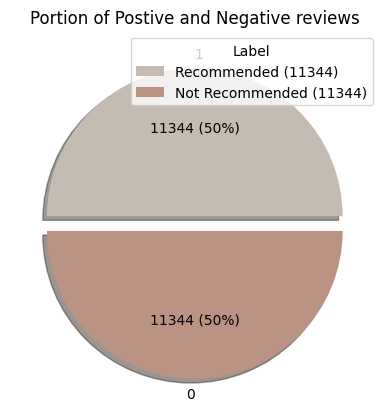

In [13]:
# Plot dependent variable distribution
# parameters for plot
sizes = df_full['Label'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#c4bcb3', '#bb9383']  

# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Label", loc="upper right", labels=[f"Recommended ({sizes[0]})", f"Not Recommended ({sizes[1]})"])
plt.show()


In [14]:
df_full["Preprocessed Review Text"] = df_full["Review Text"].astype(str).apply(lambda text: remove_punctuation(text))
df_full["Preprocessed Title"] = df_full["Title"].astype(str).apply(lambda text: remove_punctuation(text))
df_full["Combined Preprocessed"] = df_full["Preprocessed Review Text"] + " " + df_full["Preprocessed Title"]

all_features = df_full['Combined Preprocessed'].astype(str).str.lower()
review_features = df_full["Preprocessed Review Text"].astype(str).str.lower()
title_features = df_full["Preprocessed Title"].astype(str).str.lower()

/tmp/ipykernel_34/1891879523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["Preprocessed Review Text"] = df_full["Review Text"].astype(str).apply(lambda text: remove_punctuation(text))
/tmp/ipykernel_34/1891879523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["Preprocessed Title"] = df_full["Title"].astype(str).apply(lambda text: remove_punctuation(text))
/tmp/ipykernel_34/1891879523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [15]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_features)
word_index = tokenizer.word_index
review_text_sequences = tokenizer.texts_to_sequences(review_features)
title_sequences = tokenizer.texts_to_sequences(title_features)
# Pad sequences to ensure uniform length
max_sequence_length =  115 #

review_padded_sequences = pad_sequences(review_text_sequences, maxlen=max_sequence_length)
title_padded_sequences = pad_sequences(title_sequences, maxlen=max_sequence_length)


In [16]:
# Load GloVe embeddings
embedding_index = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
# Create embedding matrix
embedding_dim = coefs.shape[0]  # Assuming we use 100-dimensional GloVe vectors
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [17]:
words= []
# Calculate percentage covered words
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        words.append(word)
print('{} words covered.'.format(len(words)))
percentage = (len(words) / vocabulary_size) * 100.00
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

12526 words covered.
60.732121212121214% of 20625 words were covered


In [18]:
labels = np.array(df_full['Label'], np.int32)
labels = to_categorical(labels)

In [26]:
df_features = df_full[['Age','Rating','Positive Feedback Count']]
#df_features = df_full[['Rating']]
#df_dummies = df_full[['Division Name','Department Name','Class Name']]
#df_dummies = pd.get_dummies(df_dummies)
#df_features = df_features.join(df_dummies).replace({True:1,False:0})
non_seq_data = df_features.to_numpy()
# joint data frame
#df_combined = df_dummies.join(df_full['Recommended IND'])

# # Set the size of the heatmap
# plt.figure(figsize=(30, 24))

# # Create the heatmap
# sns.heatmap(df_combined.corr(), annot=True, cmap='coolwarm', linewidths=0.5)

# plt.savefig('correlation heat map')
# # Display the heatmap
# plt.show()

/tmp/ipykernel_34/2276307647.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features = df_features.join(df_dummies).replace({True:1,False:0})


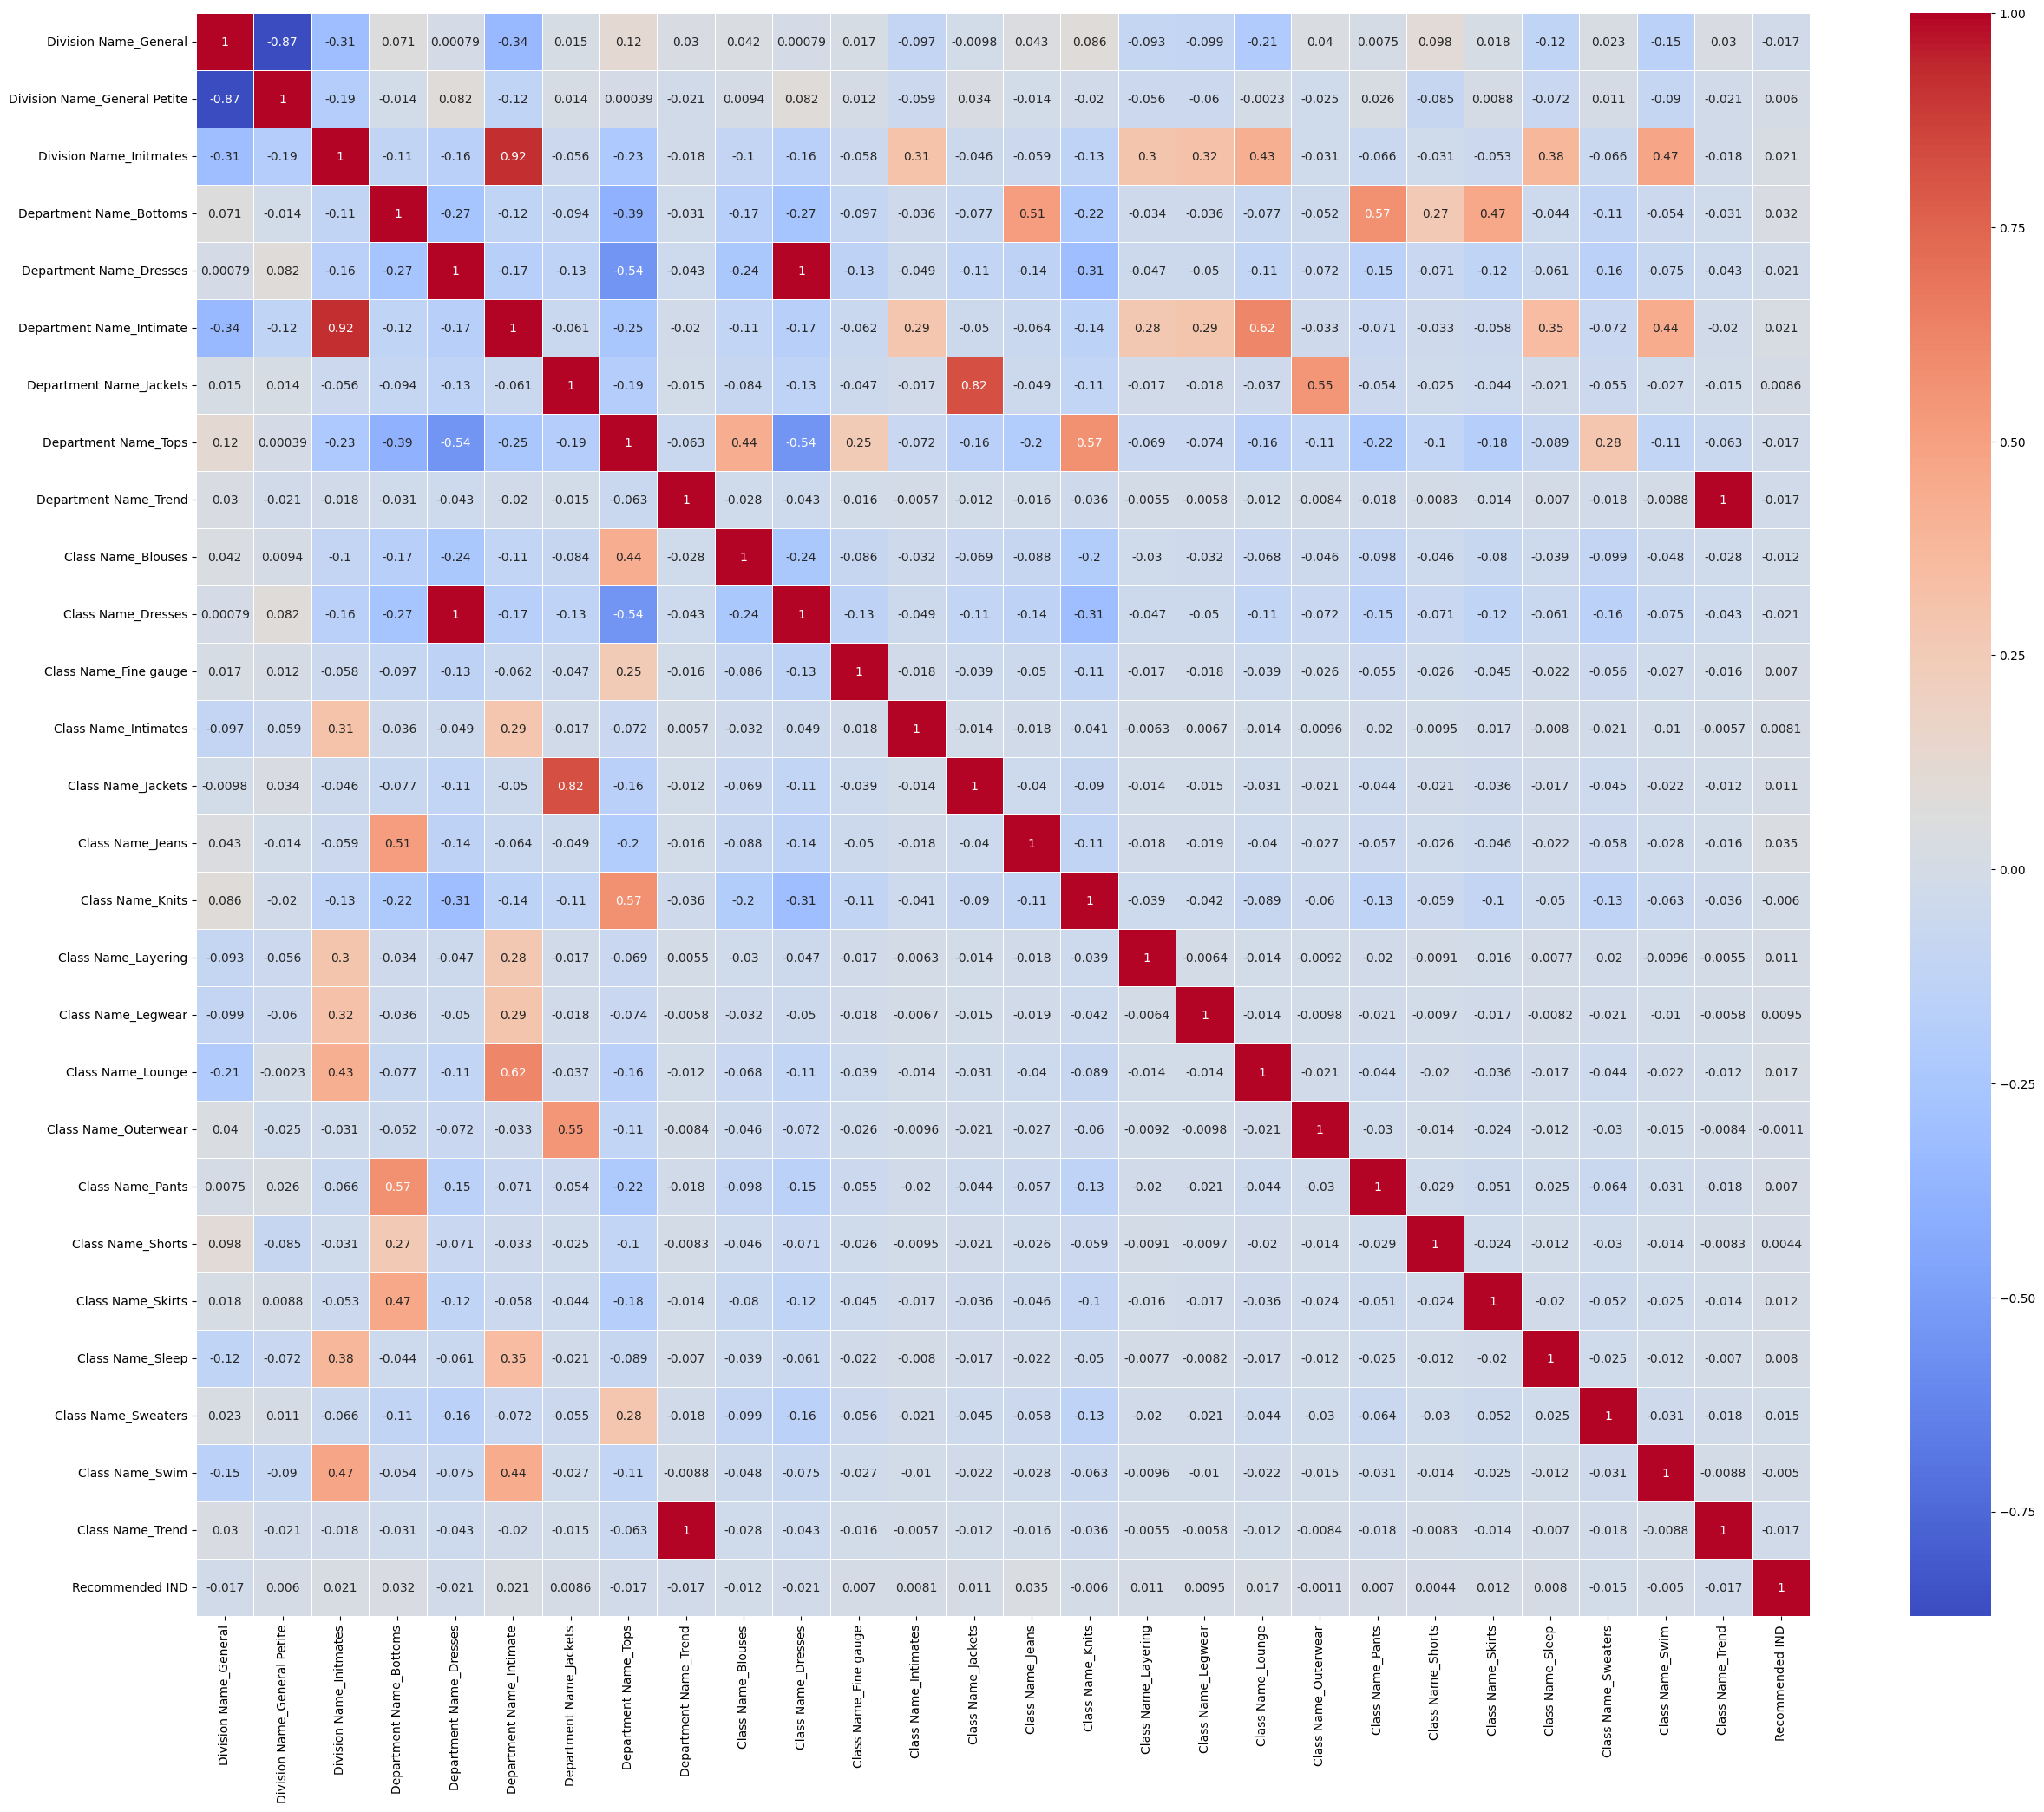

In [19]:
df_features = df_full[['Age','Rating','Positive Feedback Count']]
#df_features = df_full[['Rating']]
df_dummies = df_full[['Division Name','Department Name','Class Name']]
df_dummies = pd.get_dummies(df_dummies)
df_features = df_features.join(df_dummies).replace({True:1,False:0})
non_seq_data = df_features.to_numpy()
# joint data frame
df_combined = df_dummies.join(df_full['Recommended IND'])

# Set the size of the heatmap
plt.figure(figsize=(30, 24))

# Create the heatmap
sns.heatmap(df_combined.corr(), annot=True, cmap='coolwarm', linewidths=0.5)

plt.savefig('correlation heat map')
# Display the heatmap
plt.show()

In [20]:
# Split data into training and test sets for reviews and titles
X_review, X_test_review, y, y_test = train_test_split(review_padded_sequences, labels, test_size=0.2, random_state=43)
X_title, X_test_title = train_test_split(title_padded_sequences, test_size=0.2, random_state=43)
X_nonseq, X_test_nonseq = train_test_split(non_seq_data, test_size = 0.2, random_state=43)

X_train_review, X_val_review, y_train, y_val = train_test_split(X_review, y, test_size=0.2, random_state=43)
X_train_title, X_val_title = train_test_split(X_title, test_size=0.2, random_state=43)
X_train_nonseq, X_val_nonseq = train_test_split(X_nonseq, test_size = 0.2, random_state=43)

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the optimizer with a specific learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Define input layers
review_input = Input(shape=(X_train_review.shape[1],), name='review_input')
title_input = Input(shape=(X_train_title.shape[1],), name='title_input')
non_text_input = Input(shape=(X_train_nonseq.shape[1],), name='nontext_input')

# Define embedding layer (shared)
embedding_layer = Embedding(
    input_dim=vocabulary_size,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

# Process review input
review_embedded = embedding_layer(review_input)
review_conv1 = Conv1D(filters=128, kernel_size=5, activation='elu')(review_embedded)
review_pool1 = MaxPooling1D(pool_size=2)(review_conv1)
review_conv2 = Conv1D(filters=64, kernel_size=5, activation='elu')(review_pool1)
review_pool2 = MaxPooling1D(pool_size=2)(review_conv2)
review_lstm = (LSTM(64, return_sequences=False))(review_pool2)
review_dropout = Dropout(0.3)(review_lstm)

# Process title input
title_embedded = embedding_layer(title_input)
title_conv1 = Conv1D(filters=64, kernel_size=3, activation='elu')(title_embedded)
title_pool1 = MaxPooling1D(pool_size=2)(title_conv1)
title_conv2 = Conv1D(filters=32, kernel_size=3, activation='elu')(title_pool1)
title_pool2 = MaxPooling1D(pool_size=2)(title_conv2)
title_lstm = (LSTM(16, return_sequences=False))(title_pool2)
title_dropout = Dropout(0.3)(title_lstm)

# Concatenate the processed inputs
concatenated = concatenate([review_dropout, title_dropout, non_text_input])

# Add fully connected layers
FC_1 = Dense(128, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated)
FC_1 = Dropout(0.3)(FC_1)
FC_2 = Dense(64, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.01))(FC_1)
FC_2 = Dropout(0.3)(FC_2)

# Add final dense layer
output = Dense(2, activation='sigmoid')(FC_2)

# Define the model
model = Model(inputs=[review_input, title_input, non_text_input], outputs=output)

# Compile the model with precision, recall, and AUC metrics
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [43]:
history_3 = model.fit(
    [X_train_review, X_train_title, X_train_nonseq], y_train,
    epochs=20,
    batch_size= 128,
    validation_data=([X_val_review, X_val_title, X_val_nonseq], y_val),
    verbose=1
)

model.summary()

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.5378 - auc: 0.5435 - loss: 2.7074 - precision: 0.5299 - recall: 0.5467 - val_accuracy: 0.8917 - val_auc: 0.9582 - val_loss: 2.1768 - val_precision: 0.8804 - val_recall: 0.9083
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.8429 - auc: 0.8758 - loss: 2.1391 - precision: 0.8026 - recall: 0.8022 - val_accuracy: 0.9369 - val_auc: 0.9836 - val_loss: 1.6929 - val_precision: 0.9350 - val_recall: 0.9388
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.9254 - auc: 0.9637 - loss: 1.7023 - precision: 0.9188 - recall: 0.9198 - val_accuracy: 0.9405 - val_auc: 0.9876 - val_loss: 1.4419 - val_precision: 0.9393 - val_recall: 0.9424
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9394 - auc: 0.9775 - loss: 1.4304 - precision: 0.9370 - recall: 0.9392 - val_accuracy: 0.9485 - val_auc: 0.9901 - val_loss: 1.2365 - val_precision: 0.9473 - val_recall: 0.9510
Epoch 5/20
114/114 ━

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ review_input        │ (None, 115)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 115)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 115, 100)  │  2,062,500 │ review_input[0][… │
│ (Embedding)         │                   │            │ title_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 111, 128)  │     64,128 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 113, 64)   │     19,264 │ embedding_6[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 55, 128)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 56, 64)    │          0 │ conv1d_20[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 51, 64)    │     41,024 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 54, 32)    │      6,176 │ max_pooling1d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 25, 64)    │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 27, 32)    │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     33,024 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 16)        │      3,136 │ max_pooling1d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 16)        │          0 │ lstm_10[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nontext_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 110)       │          0 │ dropout_14[0][0], │
│ (Concatenate)       │                   │            │ dropout_15[0][0], │
│                     │                   │            │ nontext_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     14,208 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ dense_9[0][0]   

 Total params: 2,630,540 (10.03 MB)

 Trainable params: 189,346 (739.63 KB)

 Non-trainable params: 2,062,500 (7.87 MB)

 Optimizer params: 378,694 (1.44 MB)

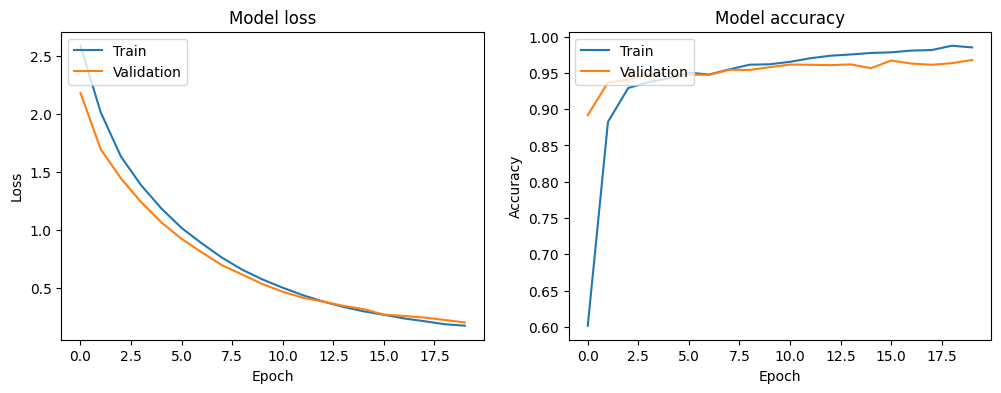

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [46]:
result = model.evaluate([X_test_review, X_test_title, X_test_nonseq], y_test)

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9700 - auc: 0.9966 - loss: 0.1958 - precision: 0.9700 - recall: 0.9700


In [47]:
print(model.predict([X_test_review, X_test_title, X_test_nonseq]))
y_pred = model.predict([X_test_review, X_test_title, X_test_nonseq])
for i in range(y_pred.shape[0]):
    if y_pred[i,0] < y_pred[i,1]:
        y_pred[i] = [0,1]
    else:
        y_pred[i] = [1,0]

142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
[[0.9989328  0.00122708]
 [0.00107935 0.99879336]
 [0.9989654  0.00117923]
 ...
 [0.99887097 0.00128219]
 [0.8860794  0.1183331 ]
 [0.9108063  0.09331365]]
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(accuracy_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (micro):", precision_score(y_test, y_pred, average='micro'))
print("Recall (micro):", recall_score(y_test, y_pred, average='micro'))
print("F1 Score (micro):", f1_score(y_test, y_pred, average='micro'))
print(classification_report(y_test, y_pred))

0.9647421771705598
Accuracy: 0.9647421771705598
Precision (micro): 0.9647421771705598
Recall (micro): 0.9647421771705598
F1 Score (micro): 0.9647421771705598
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2273
           1       0.97      0.95      0.96      2265

    accuracy                           0.96      4538
   macro avg       0.96      0.96      0.96      4538
weighted avg       0.96      0.96      0.96      4538



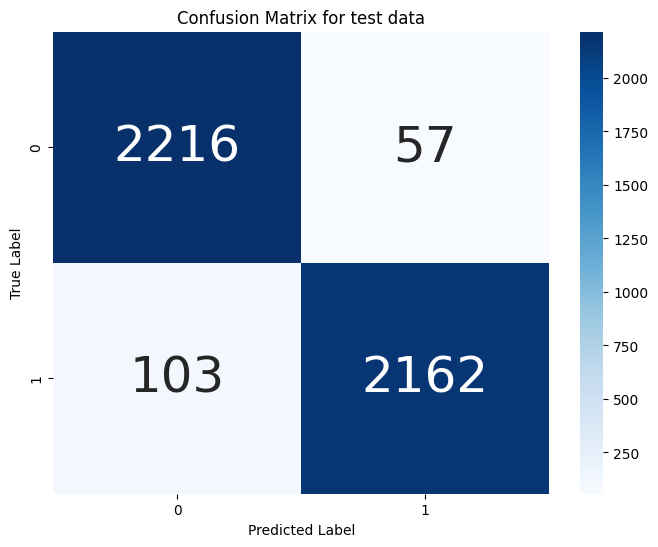

In [48]:
from sklearn.metrics import confusion_matrix
# Convert one-hot encoded labels to integers
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 36})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for test data')
plt.show()